# Classification: premier modèle avec les SVM

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/modelisation/2_SVM.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=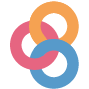" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Pour illustrer le travail d’exploration des données nécessaire avant de construire un modèle de Machine Learning, nous allons partir du même jeu de données que précédemment,
c’est-à-dire les résultats des élections US 2020 présentés dans l’[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

In [2]:
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed

Dans ce TD, nous aurons besoin des packages suivants:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

## La méthode des SVM (Support Vector Machines)

L’une des méthodes de *Machine Learning* les plus utilisées en classification est les SVM. Il s’agit de trouver, dans un système de projection adéquat (noyau ou *kernel*), les paramètres de l’hyperplan (en fait d’un hyperplan à marges maximales) séparant les classes de données:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

{{% box status=“hint” title=“Formalisation mathématique” icon=“fa fa-lightbulb” %}}
On peut, sans perdre de généralité, supposer que le problème consiste à supposer l’existence d’une loi de probabilité $\mathbb{P}(x,y)$ ($\mathbb{P} \to \{-1,1\}$) qui est inconnue. Le problème de discrimination
vise à construire un estimateur de la fonction de décision idéale qui minimise la probabilité d’erreur, autrement dit $\theta = \arg\min_\Theta \mathbb{P}(h_\theta(X) \neq y |x)$

Les SVM les plus simples sont les SVM linéaires. Dans ce cas, on suppose qu’il existe un séparateur linéaire qui permet d’associer chaque classe à son signe:

$$
h_\theta(x) = \text{signe}(f_\theta(x)) ; \text{ avec } f_\theta(x) = \theta^T x + b
$$

avec $\theta \in \mathbb{R}^p$ et $w \in \mathbb{R}$.

![](https://en.wikipedia.org/wiki/File:SVM_margin.png)

Lorsque des observations sont linéairement séparables, il existe une infinité de frontières de décision linéaire séparant les deux classes. Le “meilleur” choix est de prendre la marge maximale permettant de séparer les données. La distance entre les deux marges est $\frac{2}{||\theta||}$. Donc maximiser cette distance entre deux hyperplans revient à minimiser $||\theta||^2$ sous la contrainte $y_i(\theta^Tx_i + b) \geq 1$.

Dans le cas non linéairement séparable, la *hinge loss* $\max\big(0,y_i(\theta^Tx_i + b)\big)$ permet de linéariser la fonction de perte:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/1024px-Hinge_loss_vs_zero_one_loss.svg.png)

ce qui donne le programme d’optimisation suivant:

$$
\frac{1}{n} \sum_{i=1}^n \max\big(0,y_i(\theta^Tx_i + b)\big) + \lambda ||\theta||^2
$$

La généralisation au cas non linéaire implique d’introduire des noyaux transformant l’espace de coordonnées des observations.

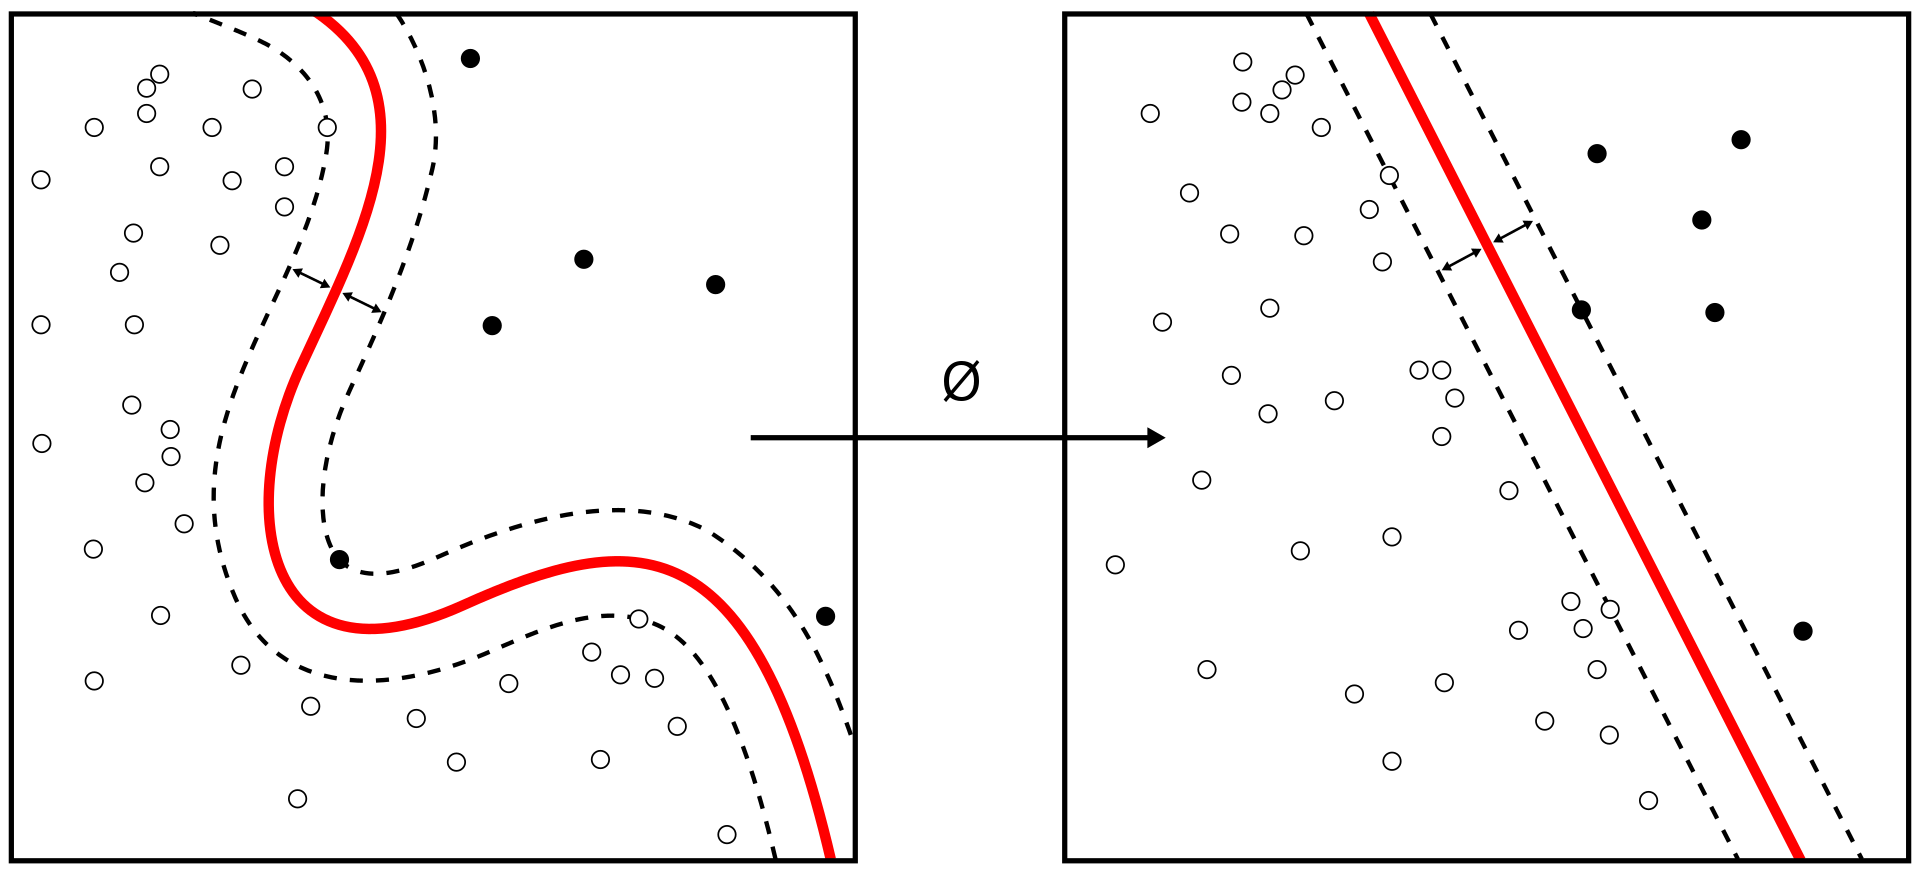

{{% /box %}}

## Exercice

{{% box status=“exercise” title=“Exercice” icon=“fas fa-pencil-alt” %}}

**Exercice 1 : Premier algorithme de classification**

In [5]:
# packages utiles
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

1.  Créer une variable *dummy* appelée `y` dont la valeur vaut 1 quand les républicains l’emportent.

2.  En utilisant la fonction prête à l’emploi nommée `train_test_split` de la librairie `sklearn.model_selection`,
    créer des échantillons de test (20 % des observations) et d’estimation (80 %) avec comme *features*: `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et comme *label* la variable `y`.

> A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

*Note : Pour éviter ce warning à chaque fois que vous estimez votre modèle, vous pouvez utiliser `DataFrame[['y']].values.ravel()` plutôt que `DataFrame[['y']]` lorsque vous constituez vos échantillons.*

1.  Entraîner un classifieur SVM avec comme paramètre de régularisation `C = 1`. Regarder les mesures de performance suivante : `accuracy`, `f1`, `recall` et `precision`.

Le classifieur avec `C = 1` devrait avoir les performances suivantes:

``` python
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])
print(out.to_markdown())
```

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.868167 |
| Recall    | 0.878307 |
| Precision |  0.97456 |
| F1        | 0.923933 |

1.  Vérifier la matrice de confusion : vous devriez voir que malgré des scores en apparence pas si mauvais, il y a un problème notable.

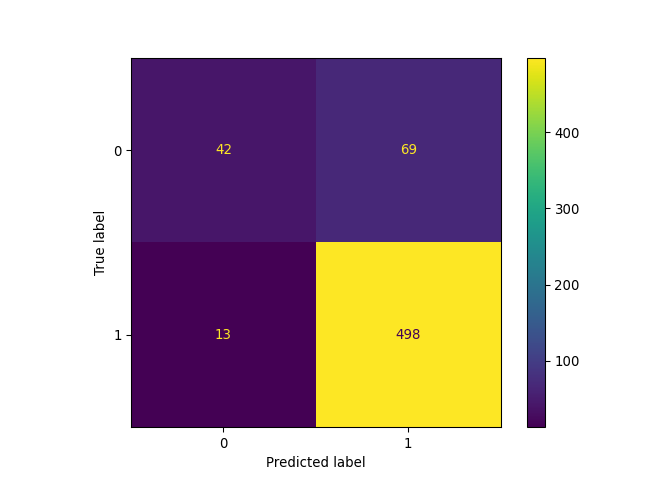

1.  Refaire les questions précédentes avec des variables normalisées. Le résultat est-il différent ?

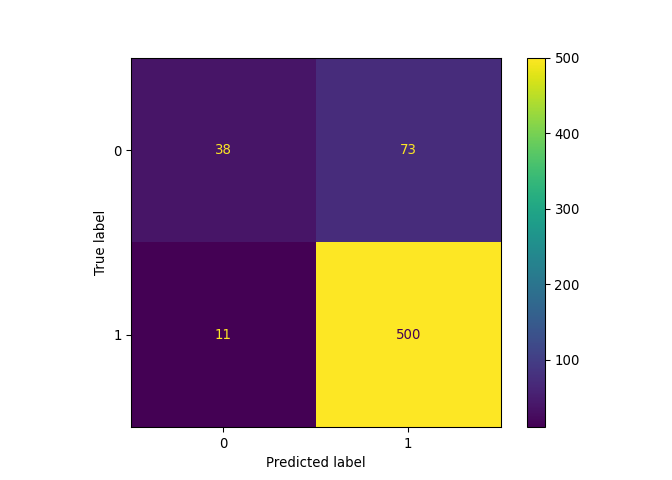

1.  Changer de variables *x*. Utiliser uniquement le résultat passé du vote démocrate et le revenu (`votes_gop` et `Median_Household_Income_2019`). Regarder les résultats, notamment la matrice de confusion.

Le nouveau classifieur avec devrait avoir les performances suivantes :

``` python
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])
print(out.to_markdown())
```

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.868167 |
| Recall    | 0.878307 |
| Precision |  0.97456 |
| F1        | 0.923933 |

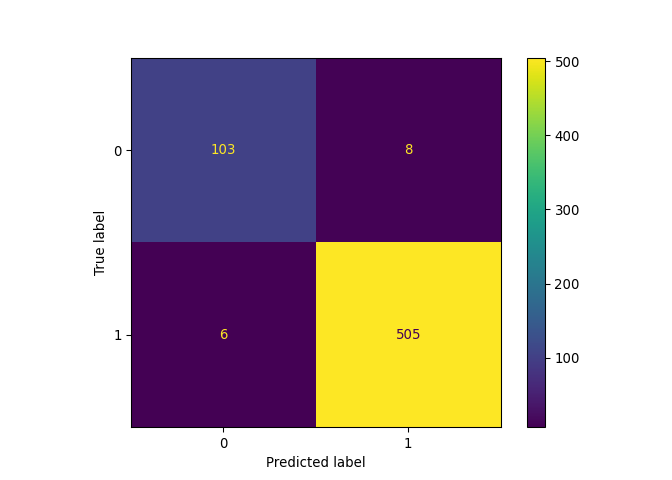

1.  \[OPTIONNEL\] Faire une 5-fold validation croisée pour déterminer le paramètre *C* idéal.

In [14]:
# TODO : correction à rédiger.

{{% /box %}}